# Deep learning framework example

This notebook demonstrates how to use the deeplearning API to train and test the model on the [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris).

To install the necessary software, use `make deps` in the root directory of the project.  If you don't have make installed or don't want to use it, then use:

`pip install -r src/python/requirements.txt`

In [1]:
# set up notebook environment
import sys
app_root_dir = '..'
sys.path.append(app_root_dir + '/src/python')
sys.path.append(app_root_dir + '/test/python')

import torch
# set the random seed so things are predictable
torch.manual_seed(7)

## Create the object factory

This creates a factoty that instantiates Python objects using a simple configuration (INI).  This removes much of the complexity of creating and "hooking up" all the instances.

In [2]:
import logging
from zensols.config import ExtendedInterpolationEnvConfig as AppConfig
from zensols.config import ImportConfigFactory
from zensols.deeplearn import ModelResultGrapher

# configure the environment
config = AppConfig(app_root_dir + '/test-resources/iris/iris-poor.conf',
                   env={'app_root': app_root_dir})

# create a factoty that instantiates Python objects using a simple configuration (INI)
factory = ImportConfigFactory(config, shared=True)

## Create the model executor

Use the factory to create the model executor (see the `executor` section of `test-resources/iris/iris.conf`).  The `write` method gives statistics on the data set that is configured on the executor.

In [3]:
executor = factory('executor')
executor.write()

feature splits:
    data frame splits:
        dev: 12 (8.0%)
        test: 25 (16.7%)
        train: 113 (75.3%)
        total: 150
batch splits:
    split stash splits:
        dev: 2 (11.8%)
        test: 3 (17.6%)
        train: 12 (70.6%)
        total: 17
    total this instance: 17
    keys consistent: True


## Print the model

Every time the executor is told to train, it creates a new model.  It also stores this model to the disk every time the validation loss drops.  The method that controls the creation if `create_model`.  Note this creates a new PyTorch `torch.nn.Module` every time and isn't the same instance used by the executor.

In this case, a four deep fully connected network is created and fanned out from the 4 features (from four columns from the CSV file) to 20.  This is then reduce to the output layer having three neurons indicating which type of flower (setosa, versicolor, or virginica).

In [4]:
print(executor.create_model())

IrisNetwork(
  (fc): DeepLinearLayer(
    (seq_layers): Sequential(
      (0): Linear(in_features=4, out_features=4, bias=True)
      (1): Linear(in_features=4, out_features=3, bias=True)
    )
  )
)


## Train and test the model

This trains the model on the Iris (flower) data set and prints the results.  The PyTorch model itself is also printed.

train: 3.386, valid: 1.269 /\: 100%|███████████| 10/10 [00:00<00:00, 52.45it/s]


Name: Iris
Run index: 1
Learning rate: 0.5
    train:
        started: 05/19/2020 03:53:26:197775
        ended: 05/19/2020 03:53:26:389050
        num epochs: 10
        num data points per epoc: 113
        loss: 0.028672388695223396
        num outcomes: 1130
        epoch convergence: 7
        micro: F1: 0.559, precision: 0.56, recall: 0.56
        macro: F1: 0.552, precision: 0.55, recall: 0.56
    validation:
        num epochs: 10
        num data points per epoc: 12
        loss: 0.17488147704279983
        num outcomes: 120
        epoch convergence: 2
        micro: F1: 0.575, precision: 0.57, recall: 0.57
        macro: F1: 0.645, precision: 0.68, recall: 0.66
    test:
        started: 05/19/2020 03:53:26:454371
        ended: 05/19/2020 03:53:26:455961
        num epochs: 1
        num data points per epoc: 25
        loss: 0.024502014756202697
        num outcomes: 25
        epoch convergence: 0
        micro: F1: 0.720, precision: 0.72, recall: 0.72
        macro: F1: 

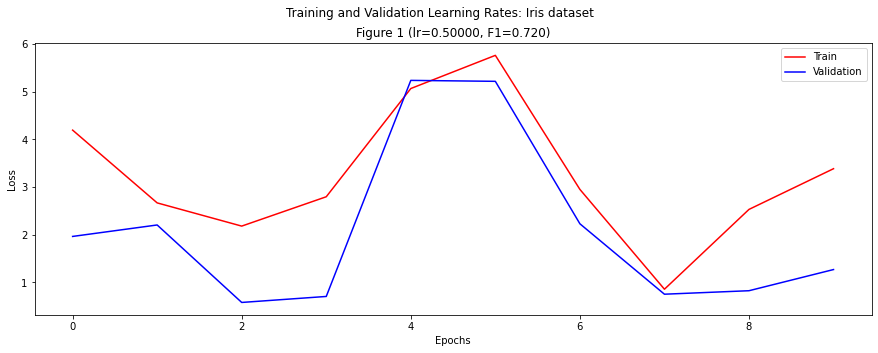

In [5]:
# tell the executor to give us console output
executor.progress_bar = True

# train the model
executor.train()

# test the model
res = executor.test()

# write a summary of the results
res.write()

# graph the results
grapher = ModelResultGrapher('Iris dataset', [15, 5])
grapher.plot([res])

## Fine tune setting hyperparameters

Now that we have our model training and we have evaluated the results, we see the validation loss is very spiky.  This means our learning rate is probably too high as when it moves during stochastic gradient descent it is "jumping" too far and back up the error surface.

To fix that, let's decrease the learning rate.  We'll probably end up modifying many of these kinds of parameters, so let's write a few functions to automate this for us.

train: 0.280, valid: 0.308 \/: 100%|█████████| 200/200 [00:14<00:00, 13.62it/s]


Name: Iris
Run index: 2
Learning rate: 0.001
    train:
        started: 05/19/2020 03:53:26:778902
        ended: 05/19/2020 03:53:41:458422
        num epochs: 200
        num data points per epoc: 113
        loss: 0.003635200685018084
        num outcomes: 22600
        epoch convergence: 199
        micro: F1: 0.825, precision: 0.83, recall: 0.83
        macro: F1: 0.824, precision: 0.86, recall: 0.83
    validation:
        num epochs: 200
        num data points per epoc: 12
        loss: 0.03322131473778024
        num outcomes: 2400
        epoch convergence: 199
        micro: F1: 0.927, precision: 0.93, recall: 0.93
        macro: F1: 0.918, precision: 0.96, recall: 0.89
    test:
        started: 05/19/2020 03:53:41:639414
        ended: 05/19/2020 03:53:41:640973
        num epochs: 1
        num data points per epoc: 25
        loss: 0.011262487649917602
        num outcomes: 25
        epoch convergence: 0
        micro: F1: 0.880, precision: 0.88, recall: 0.88
        m

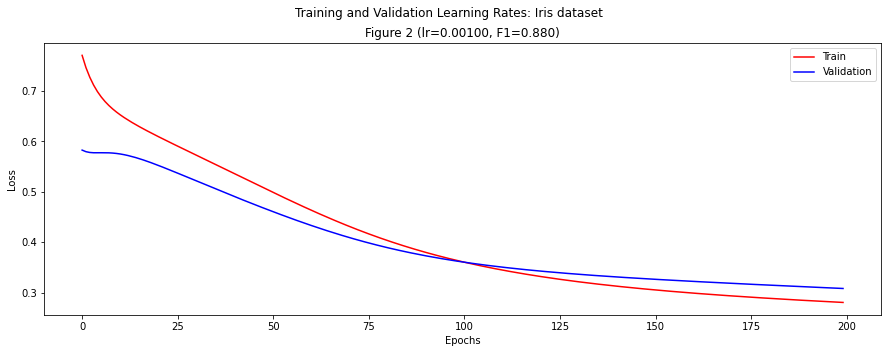

In [6]:
def set_model(name: str, value):
    # all values in the configuration are string (constraint of configparser), then later parsed to types
    value = str(value)
    config.set_option(name=name, value=value, section='model_settings')

def set_net(name: str, value):
    value = str(value)
    config.set_option(name=name, value=value, section='net_settings')

def run_model():
    # clear the previous cached version of the executor in order to create a new one so we pick up the change
    factory.shared.clear()
    executor = factory('executor', progress_bar=True)
    # train/test
    executor.train()
    res = executor.test()
    # results
    res.write()
    grapher = ModelResultGrapher('Iris dataset', [15, 5])
    grapher.plot([res])

# set the number of epochs and learning rate, which are both model parameters
set_model('epochs', 200)
set_model('learning_rate', .001)

# run the model with the new
run_model()

## Network parameters

While we're at it, let's also adjust the drop out to see if we can get better results.  Also note that the model converged pretty late (194) indicating we aren't get over training, so add more epochs.

train: 0.368, valid: 0.321 /\: 100%|███████| 1200/1200 [01:18<00:00, 15.27it/s]


Name: Iris
Run index: 3
Learning rate: 0.0007
    train:
        started: 05/19/2020 03:53:42:042284
        ended: 05/19/2020 03:55:00:602559
        num epochs: 1200
        num data points per epoc: 113
        loss: 0.003720346930512819
        num outcomes: 135600
        epoch convergence: 1063
        micro: F1: 0.750, precision: 0.75, recall: 0.75
        macro: F1: 0.749, precision: 0.75, recall: 0.75
    validation:
        num epochs: 1200
        num data points per epoc: 12
        loss: 0.03131582069003747
        num outcomes: 14400
        epoch convergence: 1173
        micro: F1: 0.974, precision: 0.97, recall: 0.97
        macro: F1: 0.966, precision: 0.97, recall: 0.96
    test:
        started: 05/19/2020 03:55:01:424276
        ended: 05/19/2020 03:55:01:425982
        num epochs: 1
        num data points per epoc: 25
        loss: 0.012109609842300416
        num outcomes: 25
        epoch convergence: 0
        micro: F1: 0.920, precision: 0.92, recall: 0.92
  

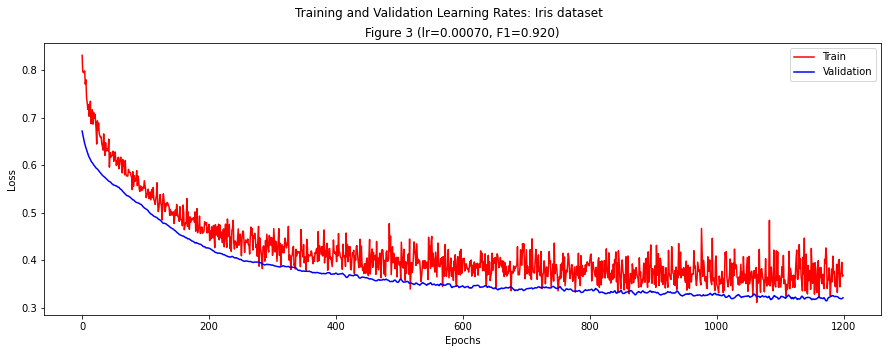

In [7]:
# set a network parameter
set_net('dropout', 0.1)
set_model('learning_rate', .0007)
set_model('epochs', 1200)
run_model()